# Production code setup

## Capture all the project stages in functions

### Cleaning the data

In [1]:
def cleaning_data(x):
    
    # Modify data types
    temp = x.astype({"month": "O", "wday": "O"})             
    
    # Fill null values
    temp.loc[x["event_name_1"].isna(),"event_name_1"] = 'no_event'

    def fill_mode(records):
        '''''
        Function that fills the null values of
        the records with values with the mode of that same product.
        Returns the same records but with no nulls.
        '''''
        mode = records["sell_price"].mode()[0]
        records.loc[records["sell_price"].isna(), "sell_price"] = mode
        return records

    temp = temp.groupby('item_id').apply(fill_mode)
      
    return(temp)

### Create variables

In [2]:
def create_variables(x):

    # Intermittent demand

    def stock_outage(sales, n):
        '''''
        Function that returns a binary variable, with a value of 1 after N days of
        0 sales in a row. It takes as an input the sales variable and the number of days
        N.
        '''''
        zero_sales = pd.Series(np.where(sales == 0, 1, 0))
        num_zeros = zero_sales.rolling(n).sum()
        stock_outage = np.where(num_zeros == n, 1, 0)

        return stock_outage
    
    x = x.sort_values(by = ['store_id','item_id','date'])
    x["stock_outage_3"] = x.groupby(["store_id", "item_id"])["sales"].transform(lambda x: stock_outage(x,3))
    x["stock_outage_7"] = x.groupby(["store_id", "item_id"])["sales"].transform(lambda x: stock_outage(x,7))
    x["stock_outage_15"] = x.groupby(["store_id", "item_id"])["sales"].transform(lambda x: stock_outage(x,15))


    # Lags variables

    def create_lags(x, variable, n_lags):
        '''''
        Function that returns a dataframe with a n_lags variables which receive the
        name of the input variable + "_lag_". Its value is just the shift of n_lags
        backwards.
        '''''
        lags = pd.DataFrame()

        #create all lags
        for i in range(1, n_lags+1):
            lags[variable + "_lag_" + str(i)] = x[variable].shift(i)

        return lags
    
    lags_sell_price_x = x.groupby(["store_id", "item_id"]).apply(lambda x: create_lags(x=x, variable="sell_price", n_lags=7))
    lags_stock_outage_3_x = x.groupby(["store_id", "item_id"]).apply(lambda x: create_lags(x=x, variable="stock_outage_3", n_lags=1))
    lags_stock_outage_7_x = x.groupby(["store_id", "item_id"]).apply(lambda x: create_lags(x=x, variable="stock_outage_7", n_lags=1))
    lags_stock_outage_15_x = x.groupby(["store_id", "item_id"]).apply(lambda x: create_lags(x=x, variable="stock_outage_15", n_lags=1))
    lags_sales_x = x.groupby(["store_id", "item_id"]).apply(lambda x: create_lags(x=x, variable="sales", n_lags=15))


    # Moving window variables

    def moving_minimum(x, variable, n_days):
        '''''
        Function that returns a dataframe with a n_days-1 variables. 
        It checks the variable "variable" and takes the minimum of the last i values
        for each record of the original dataset df.
        '''''
        mvgmin = pd.DataFrame()

        for i in range(2, n_days+1):
            mvgmin[variable + "_mvgmin_" + str(i)] = x[variable].shift(1).rolling(i).min()

        return mvgmin
    
    def moving_average(x, variable, n_days):
    
        mvgmean = pd.DataFrame()

        for i in range(2, n_days+1):
            mvgmean[variable + "_mvgmean_" + str(i)] = x[variable].shift(1).rolling(i).mean()

        return mvgmean
    
    def moving_maximum(x, variable, n_days):

        mvgmax = pd.DataFrame()

        for i in range(2, n_days+1):
            mvgmax[variable + "_mvgmax_" + str(i)] = x[variable].shift(1).rolling(i).max()

        return mvgmax
    
    moving_minimum_x = x.groupby(["store_id","item_id"]).apply(lambda x: moving_minimum(x=x, variable="sales", n_days = 15))
    moving_average_x = x.groupby(["store_id","item_id"]).apply(lambda x: moving_average(x=x, variable="sales", n_days = 15))
    moving_maximum_x = x.groupby(["store_id","item_id"]).apply(lambda x: moving_maximum(x=x, variable="sales", n_days = 15))


    # Join all the dataframes

    temp = pd.concat([lags_sell_price_x,
                    lags_stock_outage_3_x,
                    lags_stock_outage_7_x,
                    lags_stock_outage_15_x,
                    lags_sales_x,
                    moving_minimum_x,
                    moving_average_x,
                    moving_maximum_x], axis=1)
    
    x_concat = pd.concat([x, temp], axis=1)

    x_concat.dropna(inplace=True)

    to_remove = ["sell_price","stock_outage_3","stock_outage_7","stock_outage_15"]
    x_concat.drop(columns=to_remove, inplace=True)

    # Create a single variable for the product-store feature
    x_concat.insert(loc=0, column="product_store", value=(x_concat["store_id"] + "_" + x_concat["item_id"]))
    x_concat.drop(columns=["item_id","store_id"], inplace=True)

    return x_concat



### Feature Engineering

In [3]:
def transform_variables(x, y=None, mode="training"):
    '''
    It takes the features' dataframe x and target dataframe y (if training mode is required). 
    It returns the transformed features and the non-transformed ones in a single dataframe x.
    '''
    x.reset_index(inplace=True)

    # CATEGORICAL VARIABLES TRANSFORMATION
    name_ohe = "ohe_retail.pickle"
    name_te = "te_retail.pickle"
    path_ohe = "../data/" + name_ohe
    path_te = "../data/" + name_te

    #ONE HOT ENCODING (OHE)
    var_ohe = ["event_name_1"] # This is the variable that goes through OHE
    if mode == "training":
        # If mode = training then fit_transform and save the transformed
        # variable in a pickle file
        ohe = OneHotEncoder(sparse = False, handle_unknown = "ignore")
        ohe_x = ohe.fit_transform(x[var_ohe])
        ohe_x = pd.DataFrame(ohe_x, columns= ohe.get_feature_names_out())
        with open(path_ohe, mode="wb") as file:
            pickle.dump(ohe, file)
    else:
        # If not, it is assumed the model is already trained and the corresponding
        # pickle file is read from the data folder (and only applies transform)
        with open(path_ohe, mode="rb") as file:
            ohe = pickle.load(file)
        ohe_x = ohe.transform(x[var_ohe])
        ohe_x = pd.DataFrame(ohe_x, columns= ohe.get_feature_names_out())

    #TARGET ENCODING (TE)
    var_te = ["month","wday","weekday"] # These are the variables that need TE
    if mode == "training":
        # Make sure y has the same exact index as x
        y.reset_index(inplace=True, drop=True)
        y = y.loc[y.index.isin(x.index)]
        # If mode = training then fit_transform and save the transformed
        # variable in a pickle file
        te = TargetEncoder(min_samples_leaf = 100, return_df = False)
        te_x = te.fit_transform(x[var_te], y = y)
        var_te = [variable + "_te" for variable in var_te]
        te_x = pd.DataFrame(te_x, columns=var_te)
        with open(path_te, mode="wb") as file:
            pickle.dump(te, file)
    else:
        # If not, it is assumed the model is already trained and the corresponding
        # pickle file is read from the data folder (and only applies transform)
        with open(path_te, mode="rb") as file:
            te = pickle.load(file)
        te_x = te.transform(x[var_te])
        var_te = [variable + "_te" for variable in var_te]
        te_x = pd.DataFrame(te_x, columns=var_te)
    
    #REMOVE THE NON-TRANSFORMED VARIABLES AND JOIN ALL THE TRANSFORMED
    #ONES TOGETHER WITH x
    # Remove the non-transformed variables
    x = x.drop(columns=["event_name_1", "month", "wday", "weekday"])
    # Join all the dataframes
    x = pd.concat([x, ohe_x, te_x], axis=1).set_index("date")

    # Return
    return x    


### Feature Selection

In [4]:
def feature_selection(x,y):
    '''
    Only to be used during training.
    '''
    #REMOVE THE INDEX AND THE product_store VARIABLE
    x.reset_index(drop = True,inplace = True)
    x.drop(columns="product_store",inplace = True)
    
    #MAKE SURE THAT y HAS THE SAME EXACT INDEX POSITION AS x
    y = y.loc[y.index.isin(x.index)]
    
    #COPY THE FEATURE SELECTION PROCESS DEFINED IN NOTEBOOK 5
    mutual_selector = mutual_info_regression(x,y)
    n_variables = 67
    ranking_mi = pd.DataFrame(mutual_selector, index = x.columns).reset_index()
    ranking_mi.columns = ["variable","importance_mi"]
    ranking_mi = ranking_mi.sort_values(by = "importance_mi", ascending = False)
    ranking_mi["ranking_mi"] = np.arange(0,ranking_mi.shape[0])
    variables_mi = ranking_mi.iloc[0:n_variables]["variable"]
    x_mi = x[variables_mi].copy()

    return (x_mi)
    

### Modelling

#### Training

In [5]:
def modelling(x_product, y):
    '''
    Modelling of each product individually.

    Takes the x and y data of one product, tunes the parameters for that model
    and returns the best model for that product.
    '''

    # Feature to be modelled (exclude store_id and item_id)
    var_model = x_product.columns.to_list()[2:]

    # The test_size should be similar to the time frame we want to predict when
    # the model is finished
    time_cv = TimeSeriesSplit(n_splits=3, test_size=8) 

    # Using the default option of LightGBM works very well in this case

    pipe = Pipeline([("algorithm", HistGradientBoostingRegressor())])

    grid = [    {"algorithm": [HistGradientBoostingRegressor()]
                #  "algorithm__learning_rate": [0.01, 0.025, 0.05, 0.1],
                #  "algorithm__max_iter": [50, 100, 200],
                #  "algorithm__max_depth": [5, 10, 20],
                #  "algorithm__min_samples_leaf": [500],
                #  "algorithm__scoring": ["neg_mean_absolute_error"],
                #  "algorithm__l2_regularization": [0, 0.25, 0.5, 0.75, 1],
                }
                # More algorithms could be added here if we wanted to test more
            ]
    # Apply random search
    random_search = RandomizedSearchCV(estimator = pipe,
                                   param_distributions = grid, 
                                   n_iter = 1, 
                                   cv = time_cv, 
                                   scoring = "neg_mean_absolute_error", 
                                   verbose = 0,
                                   n_jobs = -1)

    model = random_search.fit(x_product[var_model], y)

    # Get the best model from the random search
    final_model = model.best_estimator_.fit(x_product[var_model],y)

    # Returns the best model
    return (final_model)

In [6]:
def start_training(df):     
    '''
    It takes the training dataset and for each product the modelling() function is used to create
    a list with all the models for all the products.

    The training dataframe contains the features x after cleaning and transformation, as well as the target.

    It saves the trained models in a pickle format.
    '''

    product_store_list = list(df["product_store"].unique())

    list_models = []

    for i in product_store_list:
        
        # Rename for readiness
        product = i
        target = "sales"

        x = df.loc[df["product_store"] == product,:].copy().drop(columns=target).copy()
        y = df.loc[df["product_store"] == product, target].copy()

        x = transform_variables(x, y)
        x = feature_selection(x, y)

        # Call modelling function
        model = modelling(x, y)

        # Add the model to the list_models
        list_models.append((product, model))

    # Save the trained models' list
    name_models = "list_models_retail.pickle"
    path_models = "../data/" + name_models
    with open(path_models, mode="wb") as file:
        pickle.dump(list_models, file)


### Forecast

In [7]:
def start_forecast(df):
    '''
    This function makes the forecast for each product but only for 1 day.

    It takes the new dataset for making predictions.

    For each product it loads its corresponding model, selects the data for that product and
    makes the predictions.

    It returns the forecast of all products but only for 1 day after the new dataset data.
    '''

    # LOAD MODELS
    name_models = "list_models_retail.pickle"
    path_models = "../data/" + name_models
    with open(path_models, mode="rb") as file:
        list_models = pickle.load(file)

    predictions_df = pd.DataFrame(columns=["date","product","sales","prediction"])

    for i in range(0, len(list_models)):

        product = list_models[i][0]
        model = list_models[i][1]
        variables = model[0].feature_names_in_ # Each model will have different variables
        target = "sales"

        x = df.loc[df["product_store"] == product,:].copy().drop(columns=target).copy()
        y = df.loc[df["product_store"] == product, target].copy()

        date = df.reset_index().copy()
        date = date.loc[date["product_store"] == product,"date"].values

        # Transform variables (execution mode)
        x = transform_variables(x, mode="execution")

        # Select features
        x = x[variables]

        # Compute predictions
        predictions = pd.DataFrame(data = {"date": date,
                                           "product": product,
                                           "sales": y,
                                           "prediction": model.predict(x)})
        predictions["prediction"] = predictions["prediction"].astype("int")

        predictions_df = pd.concat([predictions_df, predictions], axis=0)
    
    predictions_df = predictions_df.loc[predictions_df.index == predictions_df.index.min()]
    return (predictions_df)
        

In [8]:
def recursive_forecast(x, n_days=8):
    
    '''
    This function does recursive forecasting to predict sales for the next 8 days.
        
    It takes the new dataset for making predictions.

    It must have a specific structure so the whole process can be carried out.

    In order to be recursive:

    * It is going to predict the sales for the FIRST day that it has all the data (i.e. 15 days from the oldest day - necessary to create stock, lag and moving window variables)
    * Once the forecast is done, the oldest day (record) is removed from the dataset.
    * Then for the next iteration it is going to predict the following day.

    For example:

    If the oldest day in the dataset is 09.12.2015 then the first day we can predict (and we don't
    have the data) is 24.12.2015. When sales are predicted for that day, then the record for that
    day is overwritten with the actual prediction, and the record for 09.12.2015 is removed.
    Then, the oldest day now is 10.12.2015 and the new prediction is going to be for 25.12.2015.
    '''
    
    for cada in range(0,n_days): 
        step1_df = cleaning_data(x)
        step2_df = create_variables(step1_df)
        
        #Compute prediction and take the store_id and item_id variables
        f = start_forecast(step2_df)
        f['store_id'] = f["product"].str[:4]
        f['item_id'] = f["product"].str[5:]

        #Update the sales datum with the obtained prediction
        x.loc[(x.index.isin(f.date)) & (x.store_id.isin(f.store_id)) & (x.item_id.isin(f.item_id)),'sales'] = f.prediction
                                                              
        #Removes the oldest day of the dataframe
        x = x.loc[x.index != x.index.min()]
        
    return(x)

## Process

### Training / Re-training

In [ ]:
import numpy as np
import pandas as pd
import pickle

from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder

from sklearn.feature_selection import mutual_info_regression

from sklearn.model_selection import TimeSeriesSplit

from sklearn.pipeline import Pipeline

from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

#Load data
path = "../data/work.csv"
df = pd.read_csv(path, sep=',', parse_dates=['date'], index_col='date')

#Choose the variables that are used in the project
final_variables = ['store_id',
                     'item_id',
                     'event_name_1',                     
                     'month',
                     'sell_price',                      
                     'wday',
                     'weekday',
                     'sales']

df = df[final_variables]

step1_df = cleaning_data(df)
step2_df = create_variables(step1_df)

start_training(step2_df)

### Model evaluation

In [9]:
import numpy as np
import pandas as pd
import pickle

from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder

from sklearn.feature_selection import mutual_info_regression

from sklearn.model_selection import TimeSeriesSplit

from sklearn.pipeline import Pipeline

from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error


import warnings
warnings.filterwarnings("ignore")

#Load data
path = "../data/validation.csv"
df = pd.read_csv(path, sep=',', parse_dates=['date'], index_col='date')

#Choose the variables that are used in the project
final_variables = ['store_id',
                     'item_id',
                     'event_name_1',                     
                     'month',
                     'sell_price',                      
                     'wday',
                     'weekday',
                     'sales']

df = df[final_variables]

step1_df = cleaning_data(df)
step2_df = create_variables(step1_df)

forecast_1day = start_forecast(step2_df)

print('MAE = ', mean_absolute_error(forecast_1day["sales"],forecast_1day["prediction"]))
print('MAPE = ', mean_absolute_percentage_error(forecast_1day["sales"],forecast_1day["prediction"]))

forecast_1day

MAE =  4.8
MAPE =  2251799813685248.0


,date,product,sales,prediction
2015-12-16,2015-12-16 00:00:00,CA_3_FOODS_3_090,0,-10
2015-12-16,2015-12-16 00:00:00,CA_3_FOODS_3_120,52,53
2015-12-16,2015-12-16 00:00:00,CA_3_FOODS_3_202,20,17
2015-12-16,2015-12-16 00:00:00,CA_3_FOODS_3_252,36,34
2015-12-16,2015-12-16 00:00:00,CA_3_FOODS_3_288,35,27
2015-12-16,2015-12-16 00:00:00,CA_3_FOODS_3_329,64,44
2015-12-16,2015-12-16 00:00:00,CA_3_FOODS_3_555,30,29
2015-12-16,2015-12-16 00:00:00,CA_3_FOODS_3_586,76,64
2015-12-16,2015-12-16 00:00:00,CA_3_FOODS_3_587,29,31
2015-12-16,2015-12-16 00:00:00,CA_3_FOODS_3_714,19,15


### Model deployment

In [10]:
import numpy as np
import pandas as pd
import pickle

from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder

from sklearn.feature_selection import mutual_info_regression

from sklearn.model_selection import TimeSeriesSplit

from sklearn.pipeline import Pipeline

from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_absolute_error


import warnings
warnings.filterwarnings("ignore")

#Load data
path = "../data/ProductionData.csv"
df = pd.read_csv(path, sep=',',parse_dates=['date'],index_col='date')

#Choose the variables that are used in the project
final_variables = ['store_id',
                     'item_id',
                     'event_name_1',                     
                     'month',
                     'sell_price',                      
                     'wday',
                     'weekday',
                     'sales']

df = df[final_variables]

forecast = recursive_forecast(df)

forecast

,store_id,item_id,event_name_1,month,sell_price,wday,weekday,sales
date,,,,,,,,
2015-12-17,CA_3,FOODS_3_090,NaN,12,1.00,6,Thursday,0
2015-12-17,CA_3,FOODS_3_120,NaN,12,4.98,6,Thursday,52
2015-12-17,CA_3,FOODS_3_202,NaN,12,4.68,6,Thursday,21
2015-12-17,CA_3,FOODS_3_252,NaN,12,1.58,6,Thursday,56
2015-12-17,CA_3,FOODS_3_288,NaN,12,1.50,6,Thursday,39
...,...,...,...,...,...,...,...,...
2015-12-31,CA_4,FOODS_3_329,NaN,12,2.98,6,Thursday,6
2015-12-31,CA_4,FOODS_3_555,NaN,12,1.68,6,Thursday,5
2015-12-31,CA_4,FOODS_3_586,NaN,12,1.68,6,Thursday,7


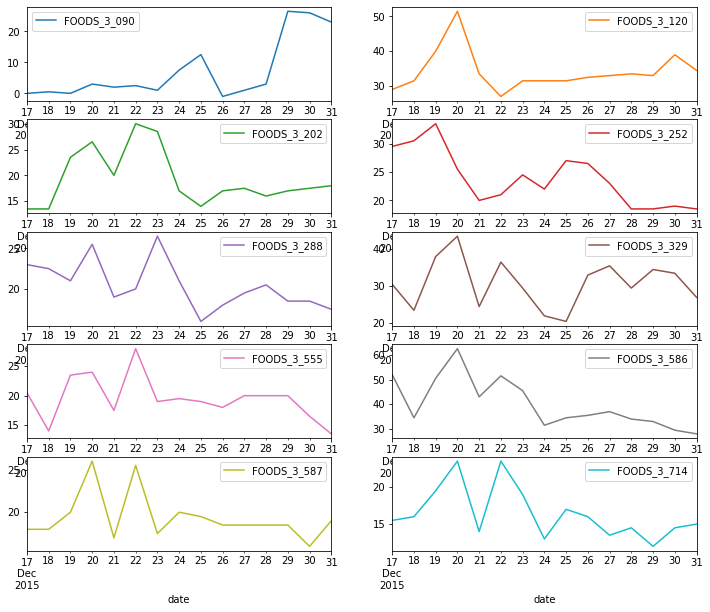

In [11]:
forecast.groupby(["item_id",forecast.index])["sales"].mean().unstack(level=0).plot(subplots=True, layout=(5,2), figsize=(12,10), sharex=False);